In [1]:
import json
import numpy as np
import os
from glob import glob
from pprint import pprint
from pathlib import Path, PosixPath
import cv2
import matplotlib.pyplot as plt

In [2]:
def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def dump_json(path, data):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as f:
        json.dump(data, f)

In [ ]:
path  = '/aidata/anders/objects/landmarks/LS3D-W/annos/BDD_LS3D-W_68_lnmk_with_crop.json'
img_lists = list(glob(os.path.join('/aidata/anders/objects/landmarks/LS3D-W/procustes', '*jpg')))
tmp = [path.split('/')[-1] for path in img_lists]

<Figure size 576x432 with 0 Axes>

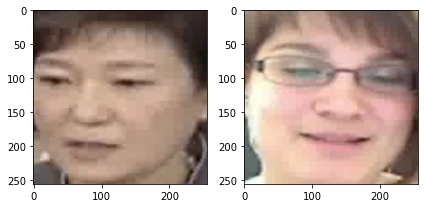

In [480]:
plt.figure(figsize=(8,6))
path =  '/aidata/anders/objects/landmarks/LS3D-W/procustes/BDD_annos.json'
img_root = '/aidata/anders/objects/landmarks/LS3D-W/procustes'
annos = load_json(path)
resize_arr = np.array([256., 256.])
points, axes = [], []
fig=plt.figure()
rows, cols = 1, 2
tmp_imgs = []
for i, frame in enumerate(annos['frame_list']):
    name = frame['name']
    img_path = os.path.join(img_root, name)
    img = cv2.imread(img_path)
    resized_ratio = resize_arr / np.asarray(img.shape[:2])
    img = cv2.resize(img, tuple(resize_arr.astype(int)))
    tmp_imgs.append(img)
    for lb in frame['labels']:
        keypoints   = lb['keypoints']
        kps = []
        for k in keypoints.keys():
            kp = np.reshape(keypoints[k], [-1, 2])
            kp  = kp * resized_ratio
            kp = np.stack(kp, axis = 0)
            kps.append(kp)
        kps = np.concatenate(kps, axis=0)
        points.append(kps)
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img[..., ::-1])
fig.tight_layout()  

In [24]:
def transformation_from_points(points1, points2):
    '''0 - 先確定是float資料型別 '''
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    '''1 - 消除平移的影響 '''
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    '''2 - 消除縮放的影響 '''
    s1 = np.std(points1, axis = 0)
    s2 = np.std(points2, axis = 0)
    points1 /= s1
    points2 /= s2

    '''3 - 計算矩陣M=BA^T；對矩陣M進行SVD分解；計算得到R '''
    # ||RA-B||; M=BA^T
    A = points1.T # 2xN
    B = points2.T # 2xN
    M = np.dot(B, A.T)
    U, S, Vt = np.linalg.svd(M)
    R = np.dot(U, Vt)

    s = s2/s1
    sR = s*R
    c1 = c1.reshape(2,1)
    c2 = c2.reshape(2,1)
    T = c2 - np.dot(sR,c1) # 模板人臉的中心位置減去 需要對齊的中心位置（經過旋轉和縮放之後）
    trans_mat = np.hstack([sR,T])   # 2x3

    return trans_mat, s

In [499]:
import math
point0, point1 = points[0][:, ::-1], points[1][:, ::-1]
trans_mat, scale  = transformation_from_points(point0, point1)
rotate_matrix = trans_mat[:, :2]/scale
cos_theta  = math.acos(rotate_matrix[0][0]) 
sin_theta  = math.asin(rotate_matrix[0][0]) 
c, d = point0.shape
expand_ones = np.ones((c, 1), dtype='f4')
coords = np.concatenate((point0, expand_ones), axis=-1)
coords = np.dot(coords, trans_mat.T)
coords = np.where(coords > 255, 255, coords)
coords = np.where(coords < 0, 0, coords)

[[ 0.99477195 -0.10212135]
 [ 0.10212135  0.99477195]]


In [529]:
from sklearn.decomposition import PCA
from sklearn import datasets
# theta_1, theta_2
theta_matrices = np.asarray([[50, 0], [30, 0], [100, 0]])
theta_matrices = theta_matrices.reshape([-1, 2])
X = theta_matrices
pca=PCA(n_components=1)
principalComponents = pca.fit(X)
components = pca.n_components_
pca.explained_variance_ratio_

(3, 2)
[[1. 0.]]
[1300.]


array([1.])

In [449]:
def warp_im(in_image, trans_mat, dst_size):
    output_image = cv2.warpAffine(in_image,
                           trans_mat,
                           dst_size,
                           flags=cv2.INTER_CUBIC,
                                   
                           borderMode=0)
    return output_image

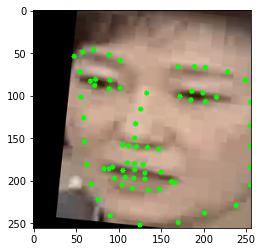

In [484]:
desired_size = 256
dst_size = (desired_size, desired_size)
img = tmp_imgs[0]
chips = warp_im(img, trans_mat, dst_size)
coords = coords.astype(int)
for coor in coords:
    aug_img = cv2.circle(chips, tuple(coor), 3, (0, 255, 0), -1)
plt.imshow(aug_img[..., ::-1])

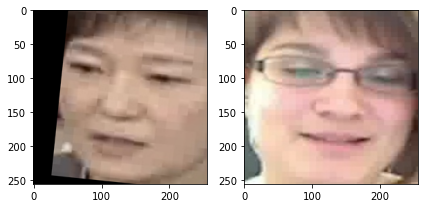

In [461]:
fig=plt.figure()
post_imgs = [chips, tmp_imgs[1]]
rows, cols = 1, 2
for i, img in enumerate(post_imgs):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img[..., ::-1])
fig.tight_layout()  

In [473]:
COLOUR_CORRECT_BLUR_FRAC = 0.6
RIGHT_EYE_POINTS= list(range(42, 48))
LEFT_EYE_POINTS = list(range(36, 42))

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)

    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
    # Avoid divide-by-zero errors.
    im2_blur = im2_blur.astype(np.float32)
    im2_blur += 128 * (im2_blur <= 1.0)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

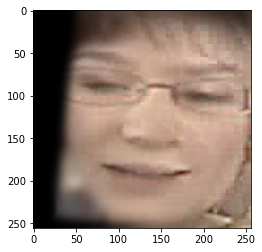

In [474]:
merged_imgs = correct_colours(chips, tmp_imgs[1], point0)
merged_imgs = merged_imgs.astype(np.uint8)
plt.imshow(merged_imgs[..., ::-1])

----------------------------------------------------------------------------------------------------
countour_face
(17, 2)
----------------------------------------------------------------------------------------------------
left_eyebrow
(5, 2)
----------------------------------------------------------------------------------------------------
right_eyebrow
(5, 2)
----------------------------------------------------------------------------------------------------
left_eye
(9, 2)
----------------------------------------------------------------------------------------------------
right_eye
(6, 2)
----------------------------------------------------------------------------------------------------
nose
(6, 2)
----------------------------------------------------------------------------------------------------
outer_lip
(12, 2)
----------------------------------------------------------------------------------------------------
inner_lip
(8, 2)


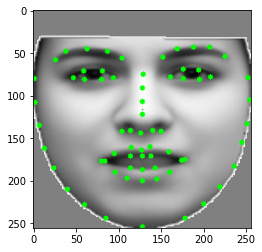

In [151]:
path = '/aidata/anders/objects/landmarks/procustes/BDD_mean_face.json'
annos = load_json(path)
for frame in annos['frame_list']:
    name = frame['name']
    img_path = os.path.join('/aidata/anders/objects/landmarks/procustes', name)
    img = cv2.imread(img_path)
    for lb in frame['labels']:
        keypoints = lb['keypoints']
        for key in keypoints.keys():
            kps = np.asarray(keypoints[key]).astype(int)
            print('-'*100)
            print(key)
            print(kps.shape)
            for kp in kps:
                img = cv2.circle(img, tuple(kp[::-1]), 3, (0, 255, 0), -1)
img  = np.asarray(img).astype(np.uint8)
plt.imshow(img)      

In [171]:
import random
LS3D_W_path = '/aidata/anders/objects/landmarks/procustes/BDD_LS3D-W_68_lnmk_with_crop.json'
annos = load_json(LS3D_W_path)
frames = annos['frame_list']
mean_face_path = '/aidata/anders/objects/landmarks/procustes/BDD_mean_face.json'
annos = load_json(mean_face_path)
mean_face_frames = annos['frame_list']
frames = mean_face_frames + frames
# frames = mean_face_frames + [frames[random.randint(0, 1e5)] for _ in range(7)] 

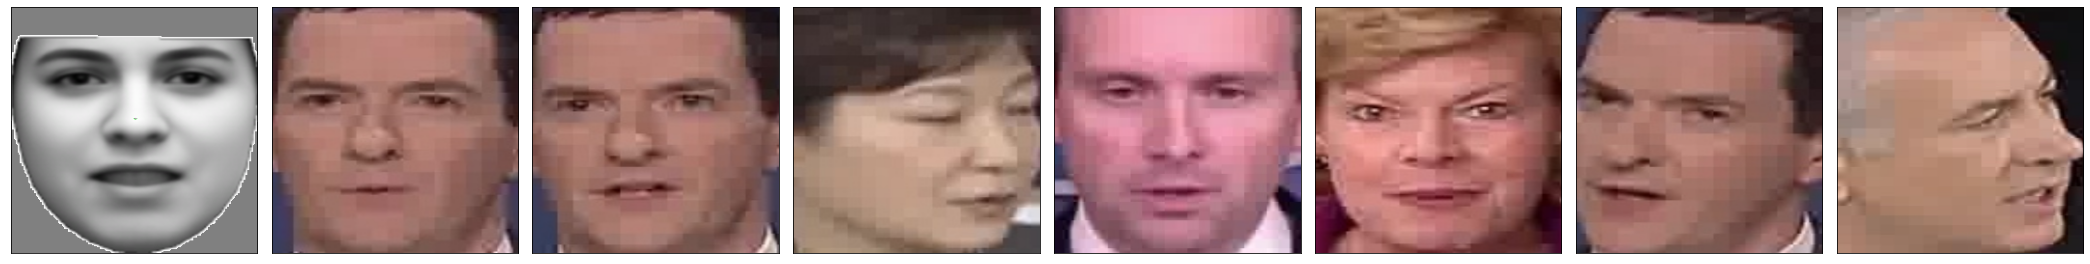

In [17]:
# TODO: use procustes analyze face shape
resize_arr = np.array([256., 256.])
points, axes = [], []
fig=plt.figure(figsize=(40, 20))
rows, cols = 1, 11
tmp_imgs = []

for i, frame in enumerate(frames):
    name = frame['name']
    if name == 'mean_face.png':
        img_root = '/aidata/anders/objects/landmarks/procustes'
    else:
        img_root = '/aidata/anders/objects/landmarks/LS3D-W/crop_imgs'
    img_path = os.path.join(img_root, name)
    img = cv2.imread(img_path)
    resized_ratio = resize_arr / np.asarray(img.shape[:2])
    img = cv2.resize(img, tuple(resize_arr.astype(int)))
    tmp_imgs.append(img)
    for lb in frame['labels']:
        keypoints   = lb['keypoints']
        kps = []
        for k in keypoints.keys():
            kp = np.reshape(keypoints[k], [-1, 2])
            kp  = kp * resized_ratio
            kp = np.stack(kp, axis = 0)
            kps.append(kp)
        kps = np.concatenate(kps, axis=0)
        points.append(kps)
    ax = fig.add_subplot(rows, cols, i+1)
    axes.append(ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img[..., ::-1])
fig.tight_layout()  

In [18]:
print(len(points))

8


In [172]:
resize_arr = np.array([256., 256.])
points = []
tmp_imgs = []
for i, frame in enumerate(frames):
    name = frame['name']
    if name == 'mean_face.png':
        img_root = '/aidata/anders/objects/landmarks/procustes'
    else:
        img_root = '/aidata/anders/objects/landmarks/LS3D-W/crop_imgs'
    img_path = os.path.join(img_root, name)
    if not os.path.isfile(img_path):
        continue
    img = cv2.imread(img_path)
    resized_ratio = resize_arr / np.asarray(img.shape[:2])
    img = cv2.resize(img, tuple(resize_arr.astype(int)))
    for lb in frame['labels']:
        keypoints   = lb['keypoints']
        kps = []
        for k in keypoints.keys():
            kp = np.reshape(keypoints[k], [-1, 2])
            kp  = kp * resized_ratio
            kp = np.stack(kp, axis = 0)
            kps.append(kp)
        kps = np.concatenate(kps, axis=0)
        points.append(kps)

AttributeError: 'NoneType' object has no attribute 'shape'

In [173]:
import math
mean_pts =  [points[0]] * len(points[1:]) 
other_pts = points[1:]
rotation_dergees = []
procustes_lists = zip(mean_pts, other_pts)
for procustes_list in procustes_lists:
    mean_face, other_face = procustes_list
    trans_mat, scale  = transformation_from_points(other_face, mean_face)
    rotate_matrix = trans_mat[:, :2]/scale
    theta = math.asin(rotate_matrix[0][1]) * 57.3
    rotation_dergees.append(theta)
    """
    c, d = point0.shape
    expand_ones = np.ones((c, 1), dtype='f4')
    coords = np.concatenate((point0, expand_ones), axis=-1)
    coords = np.dot(coords, trans_mat.T)
    coords = np.where(coords > 255, 255, coords)
    coords = np.where(coords < 0, 0, coords)
    """
rotate_degs_mu = np.mean(rotation_dergees)
rotate_degs_std = np.std(rotation_dergees)
print(rotate_degs_mu)
print(rotate_degs_std)

0.27213014450398454
7.7661376357869365


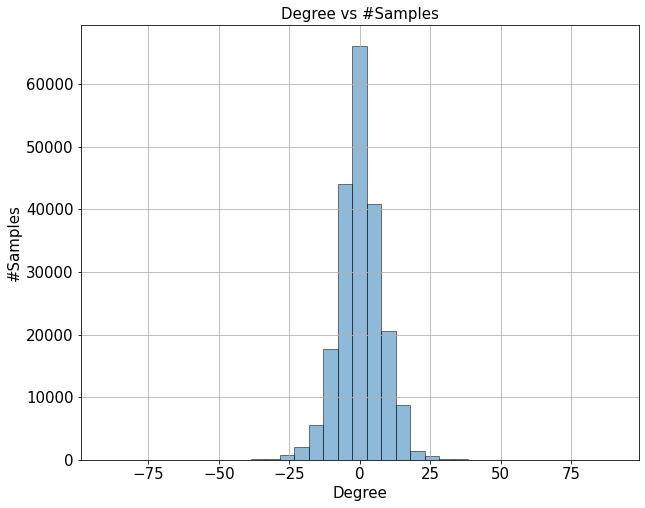

In [160]:
fig=plt.figure(figsize=(10, 8))
bins = np.linspace(-90, 90, 36)
plt.title('Degree vs #Samples',fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('#Samples', fontsize=15)
plt.hist(rotation_dergees, bins, alpha=0.5, histtype='bar', ec='black')
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.grid()
plt.show() 

In [162]:
import random
# AFLW ->68lnmk
# countour_face 0 -> 8
# left_eyebrow 0, 1, 2 -> 17, 19, 21
# right_eyebrow: 0, 1, 2 -> 22, 24, 26
# left_eye: 0, 1, 2 -> 27, 30
# right_eye: 0, 1 -> 33, 36
# nose : 0, 1, 2 -> 42, 47
# outer_lip 0, 2-> 48, 54
mapping_infos = {"countour_face": {"lnmk_68":[8], "AFLW":[0]}, "left_eyebrow":{"lnmk_68":[17, 19, 21], "AFLW":[1, 2, 3]}, 
           "right_eyebrow":{"lnmk_68":[22, 24, 26], "AFLW":[4, 5, 6]}, "left_eye":{"lnmk_68":[27, 30], "AFLW":[7, 9]}, 
           "right_eye":{"lnmk_68":[33, 36], "AFLW":[10, 12]}, "nose":{"lnmk_68":[42], "AFLW":[13]},
          "outer_lip":{"lnmk_68":[48, 54], "AFLW":[16, 18]}}
LS3D_W_path = '/aidata/anders/objects/landmarks/AFLW/annos/BDD_AFLW_with_crop.json'
annos = load_json(LS3D_W_path)
frames = annos['frame_list']
resize_arr = np.array([256., 256.])
points = []
for i, frame in enumerate(frames):
    name = frame['name']
    if name == 'mean_face.png':
        img_root = '/aidata/anders/objects/landmarks/procustes'
    else:
        img_root = '/aidata/anders/objects/landmarks/AFLW/crop_imgs'
    img_path = os.path.join(img_root, name)
    if not os.path.isfile(img_path):
        continue
    img = cv2.imread(img_path)
    resized_ratio = resize_arr / np.asarray(img.shape[:2])
    img = cv2.resize(img, tuple(resize_arr.astype(int)))
    for lb in frame['labels']:
        keypoints   = lb['keypoints']
        kps = []
        # 'countour_face', 'left_eyebrow', 'right_eyebrow', 'left_eye', 'right_eye', 'nose', 'outer_lip', 'inner_lip'
        for k in keypoints.keys():
            kp = np.reshape(keypoints[k], [-1, 2])
            if len(kp) ==0:
                continue
            kp  = kp * resized_ratio
            kps.append(kp)
        kps = np.concatenate(kps, axis=0)
        # post pick needing  kps
        tmp_kps = []
        for k  in mapping_infos:
            infos =  mapping_infos[k]
            if i==0:
                for j in infos['lnmk_68']:
                    tmp_kps.append(kps[j])
            else:
                 for j in infos['AFLW']:
                    tmp_kps.append(kps[j])
        kps = np.stack(tmp_kps)
        """
        for kp in kps[13:14]:
            kp = np.asarray(kp).astype(int)
            img = cv2.circle(img, tuple(kp[::-1]), 3, (0, 255, 0), -1)
        plt.imshow(img[:, :, ::-1])
        
        """
        points.append(kps)

/home/anders/anaconda3/envs/anders_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/anders/anaconda3/envs/anders_py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


0.0190081195519908
13.887170270843862


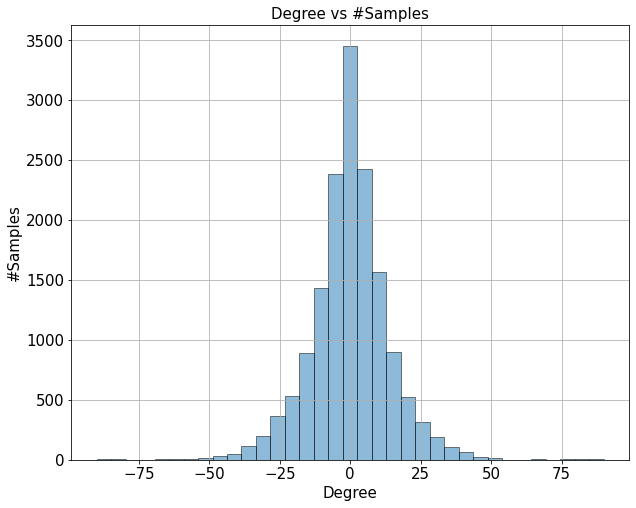

In [167]:
import math
mean_pts =  [points[0]] * len(points[1:]) 
other_pts = points[1:]
rotation_dergees = []
procustes_lists = zip(mean_pts, other_pts)
for procustes_list in procustes_lists:
    mean_face, other_face = procustes_list
    trans_mat, scale  = transformation_from_points(other_face, mean_face)
    rotate_matrix = trans_mat[:, :2]/scale
    theta = math.asin(rotate_matrix[0][1]) * 57.3
    rotation_dergees.append(theta)
rotation_dergees = np.where(np.isnan(rotation_dergees), 0, rotation_dergees)
rotate_degs_mu = np.mean(rotation_dergees)
print(rotate_degs_mu)

rotate_degs_std = np.std(rotation_dergees)
print(rotate_degs_std)
fig=plt.figure(figsize=(10, 8))
bins = np.linspace(-90, 90, 36)
plt.title('Degree vs #Samples',fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('#Samples', fontsize=15)
plt.hist(rotation_dergees, bins, alpha=0.5, histtype='bar', ec='black')
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.grid()
plt.show() 

In [149]:
#AFLW
# "roll","pitch","yaw",
def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]

campose_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/campose.txt")
facepose_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/facepose.txt")
alfw_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/alfw.txt")
faceid_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/faceid.txt") 


img_root= "/aidata/evianlee/dataset/AFLW/clean/ALFW_clean/ALFW_clean/data"
fig=plt.figure(figsize=(40, 20))
axes =  []
rows, cols = 1, 4
a =0
rolls = []
pitchs = []
yaws = []

# image71361.jpg
for i, (caampose_line, facepose_line, faceid_line) in enumerate(zip(campose_lines[1:], facepose_lines[1:], faceid_lines[1:])):
    name =str(caampose_line.split(",")[0])
    file_name = faceid_line.split(",")[1]
    tmp_str = str()
    for i, n in enumerate(file_name):
        if i > 0 and i < len(file_name) -1:
            tmp_str +=n
    name = tmp_str
    img_path = os.path.join(img_root, name)
    img = cv2.imread(img_path)
    if img is None:
        continue
    a += 1
    # "roll","pitch","yaw"
    # axes.append(fig.add_subplot(rows, cols, a))
    # plt.imshow(img[..., ::-1])
    roll = facepose_line.split(",")[1]
    tmp_str = str()
    for i, n in enumerate(roll):
        if i > 0 and i < len(roll) -1:
            tmp_str +=n
    roll = float(tmp_str) * 57.3 
    rolls.append(roll)
    
    pitch = facepose_line.split(",")[2]
    tmp_str = str()
    for i, n in enumerate(pitch):
        if i > 0 and i < len(pitch) -1:
            tmp_str +=n
    pitch = float(tmp_str) * 57.3 
    pitchs.append(pitch)
    yaw = facepose_line.split(",")[3]
    tmp_str = str()
    for i, n in enumerate(yaw):
        if i > 0 and i < len(yaw) -1:
            tmp_str +=n
    yaw = float(tmp_str) * 57.3 
    yaws.append(yaw)    

<Figure size 2880x1440 with 0 Axes>

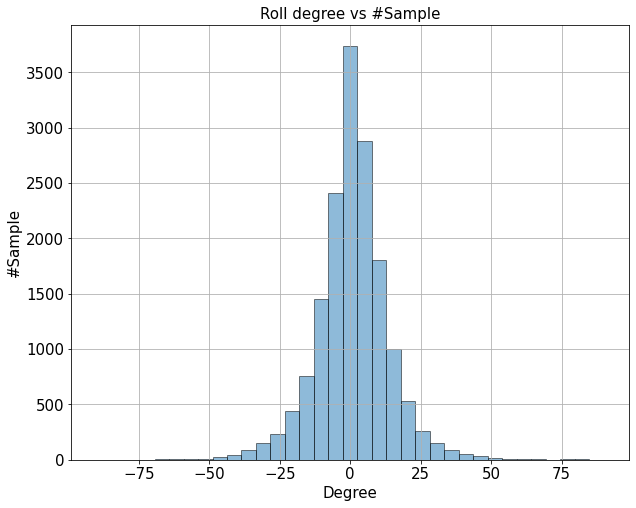

In [153]:
fig=plt.figure(figsize=(10, 8))
bins = np.linspace(-90, 90, 36)
plt.title('Roll degree vs #Sample',fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('#Sample', fontsize=15)
plt.hist(rolls, bins, alpha=0.5, histtype='bar', ec='black')
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.grid()
plt.show() 

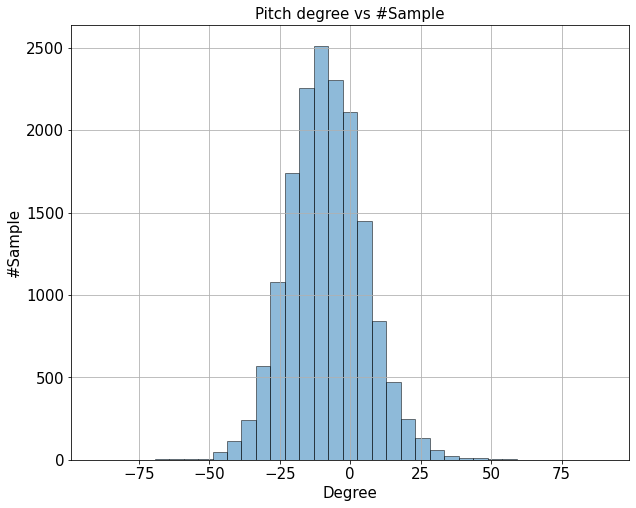

In [156]:
fig=plt.figure(figsize=(10, 8))
bins = np.linspace(-90, 90, 36)
plt.title('Pitch degree vs #Sample',fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('#Sample', fontsize=15)
plt.hist(pitchs, bins, alpha=0.5, histtype='bar', ec='black')
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.grid()
plt.show() 

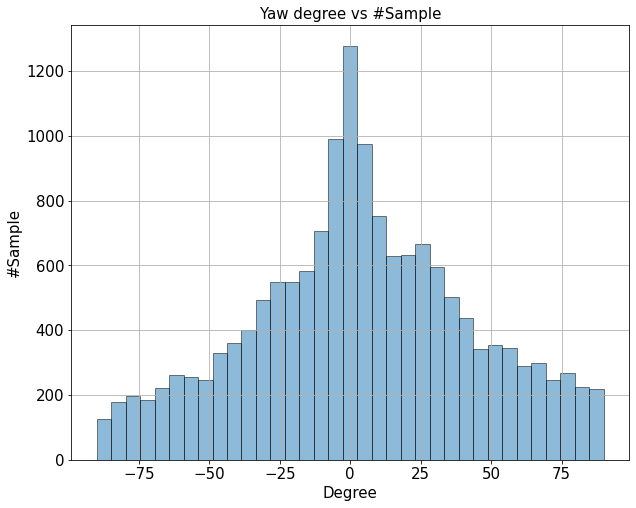

In [155]:
fig=plt.figure(figsize=(10, 8))
bins = np.linspace(-90, 90, 36)
plt.title('Yaw degree vs #Sample',fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('#Sample', fontsize=15)
plt.hist(yaws, bins, alpha=0.5, histtype='bar', ec='black')
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.grid()
plt.show() 